In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## OFI computation
OFI preprocessing and computation is carried out in `order_flow_imbalance/ofi_computation.py` by following the steps below.
1. Clean timestamps according to the date of acquisition: we consider only meaningful timestamps that are within the same day of acquisition.
2. Rescaling prices with the tick size;
3. Compute the quantities $\Delta W$ and $\Delta V$ for each timestamp;
4. Discretizig time and summing the single $e_n$ over the time interval in order to compute OFI, we fix a time interval of 1 min.

In [2]:
ofi = pd.read_csv('../data_cleaned/ofi_10_levels.csv')
OFI_values = ofi.drop(['mid_price_delta', 'time_bin', 'bin_label'], axis=1)

## Outlier detection with Isolation Forest and Linear Fit

The OFI, can be a good price predictor since it has been shown (Cont et al., (2011)) that it stands in a linear relation with the midprice, thus with the price at which it is more likely that a trades occur. 

$$ \Delta P_k = \beta \,\, OFI_k + \epsilon$$

where $ \Delta P_k $ is the variation in price at time $\tau_k$, $\beta$ is the price impact coefficient, $OFI_k$ is the order flow imbalance at time $\tau_k$, and $\epsilon$ is the error term.

Here we study not only the first level of the book, but all the first six levels, in order to verify if such linear relation holds for the whole book.

In [3]:
from sklearn.ensemble import IsolationForest
import numpy as np

Fitting level 0
Fitting level 1
Fitting level 2
Fitting level 3
Fitting level 4
Fitting level 5


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

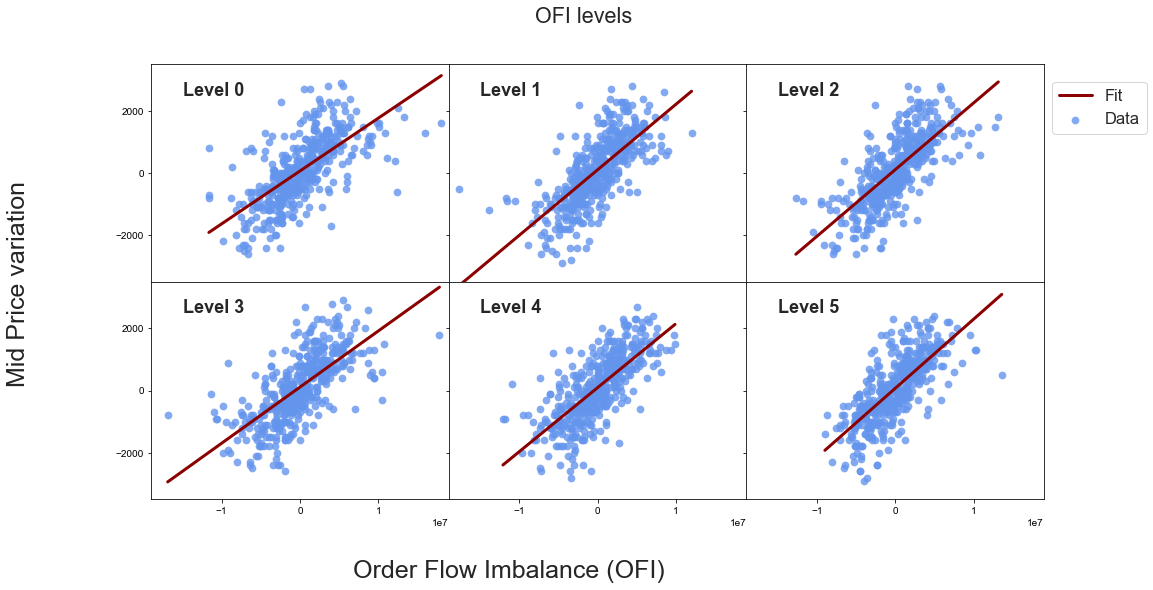

In [4]:
n_fit = 6
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,8))
sns.set_theme(style='white', font_scale=1.5)
j=0
k=0
a_coeff, b_coeff, r2_scores, mse_scores  = [], [], [], []
for i in range(n_fit):
    print('Fitting level {}'.format(i))
    if i==3: 
        j=0
        k=1
    #removing outliers 
    trend_data = np.array([ofi['OFI_{}'.format(i)], ofi['mid_price_delta']], dtype=np.float64).T
    clf = IsolationForest(n_estimators=100)
    clf.fit(trend_data)   
    outliers = [True if x==1 else False for x in clf.predict(trend_data)]
    trend_data=trend_data[outliers].T

    # linear fit
    from sklearn.linear_model import Ridge
    from sklearn.metrics import r2_score, mean_squared_error
    model=Ridge()
    model.fit(trend_data[0].reshape(-1,1),trend_data[1])
    a, b = model.coef_[0], model.intercept_
    a_coeff.append(a)
    b_coeff.append(b)
    # r2_score: proportion of the variation in the dependent 
    # variable that is predictable from the independent variable
    r2_scores.append((r2_score(trend_data[1], model.predict(trend_data[0].reshape(-1,1)))))
    mse_scores.append((mean_squared_error(trend_data[1], model.predict(trend_data[0].reshape(-1,1)))))

    #plot
    predicted=[a*x+b for x in trend_data[0]]
    sns.scatterplot(x=trend_data[0], y=trend_data[1], ax=ax[k,j], \
                    s=60, marker='o', color ='cornflowerblue',linewidth=0, alpha=0.8, label='Data')
    g=sns.lineplot(x=trend_data[0], y=predicted, ax=ax[k,j], lw=3, color='darkred', label='Fit')

    g.legend(loc='center left', bbox_to_anchor=(1, 0.8))
    if k!=0 and j!=0: ax[k,j].get_legend().remove()
    ax[k,j].set_xlabel('')
    ax[k,j].set_ylabel('')
    ax[k,j].set_xlim(-1.9e7, 1.9e7)
    ax[k,j].set_ylim(-3500, 3500)
    ax[k,j].text(-1.5e7, 2500, 'Level {}'.format(i), weight='bold')
    j+=1

#Options for the plot
fig.suptitle('OFI levels')
ax[0,0].get_shared_x_axes().join(ax[0,0], ax[1,0])
ax[0,0].set_xticklabels([])
ax[0,1].set_yticklabels('')
ax[1,1].set_yticklabels('')
ax[1,2].set_yticklabels('')
ax[0,2].set_yticklabels('')

fig.text(0, 0.5, 'Mid Price variation', rotation=90, va='center', fontsize=25)
fig.text(0.3, 0, 'Order Flow Imbalance (OFI) ', va='center', fontsize=25)
fig.subplots_adjust(hspace=.0, wspace=0.)

#output
import os 
if os.path.isdir('../figures')==False:
    os.mkdir('../figures')
fig.savefig('../figures/OFI_levels_fit.png', bbox_inches='tight')

#results
from IPython.display import display, Math
for i in range(n_fit): 
    display(Math(r'Level \,\,{} \quad \quad  \Delta \overline P = {:.4f}\,\, OFI_{} + {:.4f}'.format(i, a_coeff[i], i, b_coeff[i])+
            '\quad R^2 = {:.2f}, \quad MSE= {:.2f}'.format(r2_scores[i], mse_scores[i])))

### Multi dimensional linear fit

Now that we verified that a linear relation occurs, even though the quality of the fit does not allow us to descrie all the variance of the mid price in the book, we can use the same procedure to study the OFI in the first ten levels of the book by applying a multi dimensional linear fit. Moreover, this same strategy can be also seen as the definition of a new feature as the linear combination of the multi-level OFIs.

So we propose two strategies:

1. We apply the startegy proposed by K. Xu, M. D. Gould, and S. D. Howison (Multi-Level Order-Flow Imbalance in a Limit Order Book), which consist in a multi-dimensional linear fit by means of Ridge regression of the OFI in the first ten levels of the book:$$\Delta  P_k = \alpha+ \sum_m \beta_m OFI_m^k$$
    where $P_k $ is defined as before, and OFI_m^k$ is the OFI in the $m^{th}$ level of the book at time $\tau_k$.
    
2. 


MULTIDIMENSIONAL LINEAR REGRESSION


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/scipy/optimize/_minimize.py:541: RuntimeWarning: Method cobyla cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


Loss function optimum: 0.53


Text(0.5, 0, 'linear combination of OFI')

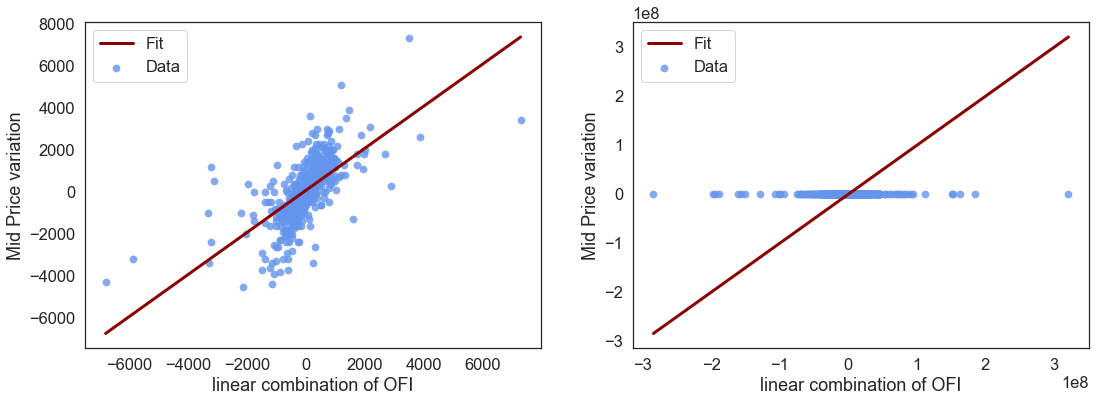

In [15]:
mid_price_delta = ofi['mid_price_delta']

# linear regression with sklearn
model=Ridge()
model.fit(OFI_values, mid_price_delta)
betas, alpha = model.coef_, model.intercept_
r2_scores=r2_score(mid_price_delta, model.predict(OFI_values))
print('MULTIDIMENSIONAL LINEAR REGRESSION')
display(Math(r'\Delta \overline P = \alpha+ \sum_m \beta_m OFI_m'))
display(Math(r'\alpha = {:.4f}'.format(alpha)))
display(Math(r'\beta =['+', \,\,'.join(['{:.6f}'.format(b) for b in betas])+']'))
display(Math(r'R^2 = {:.2f}'.format(r2_scores)))

def linear_combination(weights, data):
        """
        args:
            weights (list or np.array): list of weights
            data (list or np.array): list of OFI
        returns:
            linear combination of data
        """
        return sum([w*d for w,d in zip(weights, data)])

sns.set_theme(style='white', font_scale=1.5)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
new_feature = [linear_combination(betas, OFI_values.iloc[i,:]) for i in range(len(OFI_values))]
sns.scatterplot(x=new_feature, y=mid_price_delta, ax=ax[0], s=60, marker='o', 
                color ='cornflowerblue',linewidth=0, alpha=0.8, label='Data')
sns.lineplot(x=new_feature, y=alpha+new_feature, ax=ax[0], lw=3, color='darkred', label='Fit')
ax[0].set_ylabel('Mid Price variation')
ax[0].set_xlabel('linear combination of OFI')


# optimization of the new feature feat
def loss(weights, data_ofi, mid_price_delta):
    """
    args:
        weights: list of weights
        data_ofi: list of OFI
        mid_price_delta: list of mid price delta
    returns:
        loss of linear combination of data
    """

    if len(weights)!=len(data_ofi.columns):
        raise ValueError('weights and data_ofi.columns must have the same length')
    if len(data_ofi)!=len(mid_price_delta):
        raise ValueError('data_ofi and mid_price_delta must have the same length')

    new_feature = np.array([linear_combination(weights, data_ofi.iloc[i,:]) for i in range(len(data_ofi))])

    # We optimize over tthe weights once we defined a new feature which is the weighted sum of the OFI
    # objective is the r2 score of the linear fit

    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(trend_data[0].reshape(-1,1), trend_data[1])
    r2 = r2_score(trend_data[1], model.predict(trend_data[0].reshape(-1,1)))
    intercept = model.intercept_
    return -r2

from scipy.optimize import minimize
r=minimize(loss, x0=np.random.uniform(size=10), args=(OFI_values, mid_price_delta), 
        method='cobyla', bounds=[(0, None) for i in range(10)], options={'disp': True})

weights = r.x
new_feature = np.array([linear_combination(weights, OFI_values.iloc[i,:]) for i in range(len(OFI_values))])


print('OPTIMIZATION COMBINED WITH REGRESSION')
display(Math(r'\Delta \overline P = \alpha+ \sum_m \beta_m OFI_m'))
display(Math(r'\alpha = {:.4f}'.format(alpha)))
display(Math(r'\beta =['+', \,\,'.join(['{:.6f}'.format(b) for b in betas])+']'))
display(Math(r'R^2 = {:.2f}'.format(r2_scores)))


sns.scatterplot(x=new_feature, y=mid_price_delta, ax=ax[1], s=60, marker='o', 
                color ='cornflowerblue',linewidth=0, alpha=0.8, label='Data')
sns.lineplot(x=new_feature, y=alpha+new_feature, ax=ax[1], lw=3, color='darkred', label='Fit')
ax[1].set_ylabel('Mid Price variation')
ax[1].set_xlabel('linear combination of OFI')



## PCA and correlations

Finally, since we verified that different levels of the book exhibit the same relation with the mid price time evolution, we would expect to observe correlations within different OFI. 

To formalize this, we can use the PCA to study the correlation between the OFI in the first ten levels of the book.
We then provide the correlation matrix, and the explained variance of the principal components computed after applying PCA to the data. 
We can deduce that the first four levels tend to be more correlated if compared with higher levels, while lower levels of correlations are observed in the rest of the book. The analysis of the explained variance ratio also shows that in order to explain at least the 80% of the variance of the data we should consider at least four components in the eigenvalues space.

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(634.1681818181817, 0.5, 'Explained variance')

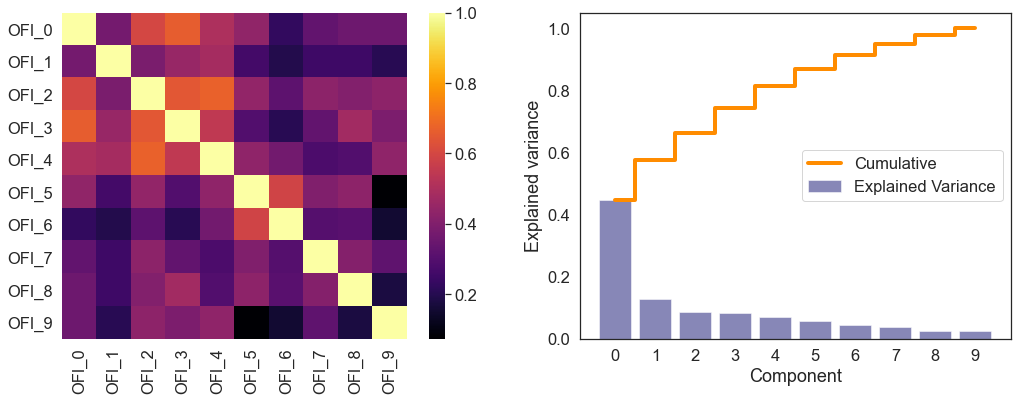

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
scaled = scaler.fit_transform(OFI_values) 
pca = PCA(n_components=None)
pca.fit(scaled)
new_ofi = pca.transform(scaled)

sns.set_theme(style='white', font_scale=1.5, palette = 'magma')
explained_var = pca.explained_variance_ratio_
fig, ax = plt.subplots(1,2, figsize=(17,6))

sns.barplot(np.arange(len(explained_var)), explained_var, alpha=0.5, color = 'navy', ax=ax[1], label='Explained Variance')
ax[1].step(np.arange(len(explained_var)), np.cumsum(explained_var),\
         drawstyle='steps-pre', color='darkorange', lw=4, where = 'mid', label='Cumulative')
plt.legend(loc='center right')
sns.heatmap(OFI_values.corr(), cmap='inferno', fmt='.1f', ax=ax[0])#annot=True
ax[1].set_xlabel('Component')
ax[1].set_ylabel('Explained variance')

## Distributions

<AxesSubplot:xlabel='level', ylabel='OFI'>

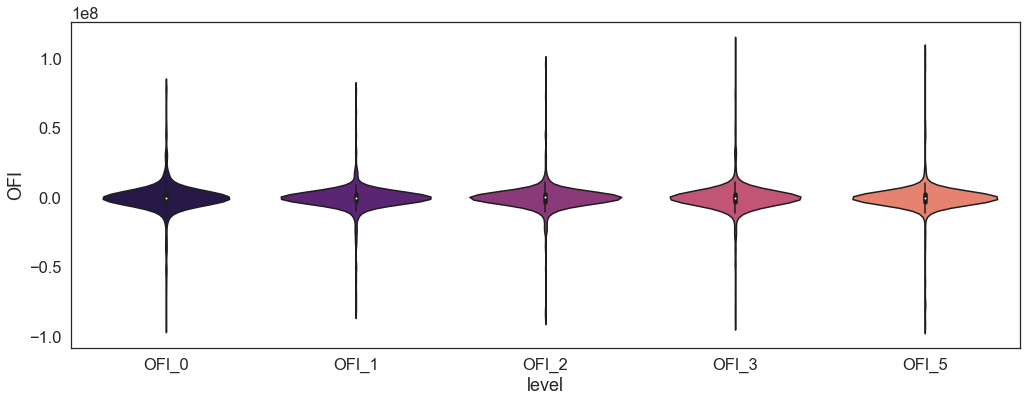

In [10]:
sns.set_theme(style='white', font_scale=1.5, palette = 'magma')
fig, ax = plt.subplots(figsize=(17,6))
df_distr = OFI_values.copy()
df_distr = df_distr.drop(['OFI_9', 'OFI_8', 'OFI_7', 'OFI_6', 'OFI_4'], axis=1)
categorical_ofi = []
levels = []
for c in df_distr.columns:
    categorical_ofi = np.concatenate([categorical_ofi, OFI_values[c]])
    levels = np.concatenate([levels, np.repeat(c, OFI_values.shape[0])])
cat_ofi = pd.DataFrame({'OFI':categorical_ofi, 'level':levels})

sns.violinplot(data=cat_ofi, x='level',y='OFI', ax=ax)


## Multivariate Time Series Forecasting with LSTMs